In [12]:
import os
from PIL import Image
from tqdm import tqdm
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split

In [10]:
df = pd.read_csv('./archive/balanced_dataset.csv')
df.head()

,image_path,category
0,D:/python files/datasets/Dermabot/balanced_dat...,Acne And Rosacea Photos
1,D:/python files/datasets/Dermabot/balanced_dat...,Acne And Rosacea Photos
2,D:/python files/datasets/Dermabot/balanced_dat...,Acne And Rosacea Photos
3,D:/python files/datasets/Dermabot/balanced_dat...,Acne And Rosacea Photos
4,D:/python files/datasets/Dermabot/balanced_dat...,Acne And Rosacea Photos


In [ ]:
dataset_path = './archive/balanced_dataset/balanced_dataset'

class_dirs = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

image_counts = {}
image_sizes = []

for class_name in class_dirs:
    class_path = os.path.join(dataset_path, class_name)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    image_counts[class_name] = len(image_files)

    for image_name in image_files:
        image_path = os.path.join(class_path, image_name)
        try:
            with Image.open(image_path) as img:
                width, height = img.size
                image_sizes.append((width, height))
        except Exception as e:
            print(f"Error al leer la imagen {image_path}: {e}")

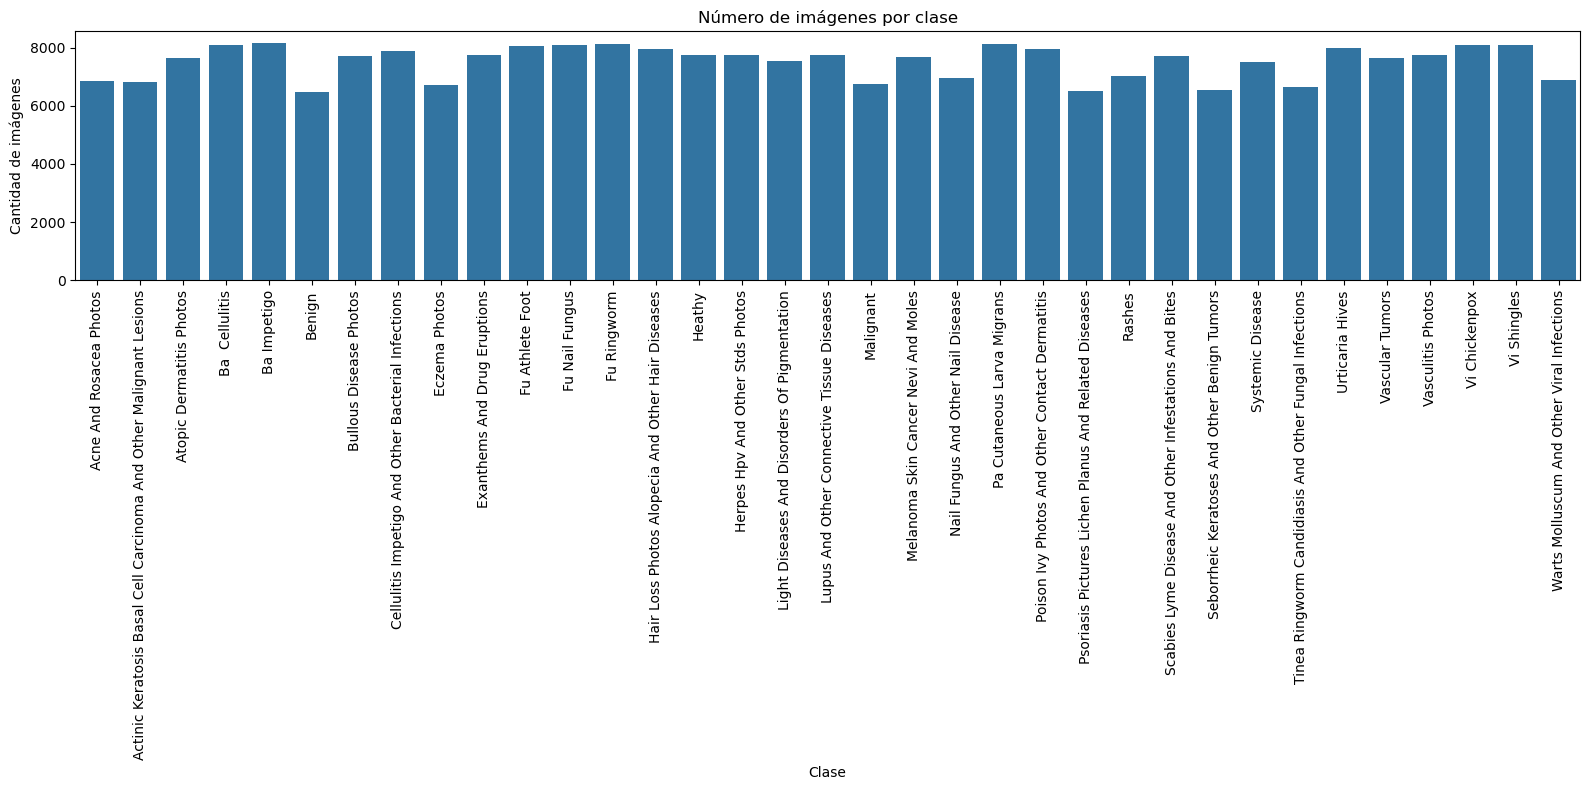

,"Resolution (W, H)",Count
0,"(224, 224)",45425
1,"(720, 472)",40629
2,"(720, 480)",20338
3,"(480, 720)",10024
4,"(128, 128)",8083
5,"(720, 464)",5583
6,"(720, 474)",4960
7,"(720, 477)",4696
8,"(472, 720)",3678
9,"(477, 720)",2841


In [ ]:
plt.figure(figsize=(16, 8))
sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()))
plt.xticks(rotation=90)
plt.title("Número de imágenes por clase")
plt.ylabel("Cantidad de imágenes")
plt.xlabel("Clase")
plt.tight_layout()
plt.show()

size_counter = Counter(image_sizes)
df_sizes = pd.DataFrame(size_counter.items(), columns=['Resolution (W, H)', 'Count']).sort_values(by='Count', ascending=False)
df_sizes.reset_index(drop=True, inplace=True)

df_sizes.head(10)

In [11]:
# Rutas
original_path = './archive/balanced_dataset/balanced_dataset'
resized_path = './redimension'
target_size = (224, 224)

os.makedirs(resized_path, exist_ok=True)

for class_name in os.listdir(original_path):
    class_dir = os.path.join(original_path, class_name)
    if not os.path.isdir(class_dir):
        continue

    target_class_dir = os.path.join(resized_path, class_name)
    os.makedirs(target_class_dir, exist_ok=True)

    for image_name in tqdm(os.listdir(class_dir), desc=f"Procesando {class_name}"):
        if not image_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        src_path = os.path.join(class_dir, image_name)
        dst_path = os.path.join(target_class_dir, image_name)

        try:
            with Image.open(src_path) as img:
                img = img.convert("RGB")
                img_resized = img.resize(target_size)
                img_resized.save(dst_path)
        except Exception as e:
            print(f"Error con la imagen {src_path}: {e}")


Procesando Acne And Rosacea Photos: 100%|██████████| 6837/6837 [00:26<00:00, 260.42it/s]
Procesando Actinic Keratosis Basal Cell Carcinoma And Other Malignant Lesions: 100%|██████████| 6821/6821 [00:26<00:00, 261.91it/s]
Procesando Bullous Disease Photos: 100%|██████████| 7695/7695 [00:27<00:00, 275.36it/s]
Procesando Cellulitis Impetigo And Other Bacterial Infections: 100%|██████████| 7894/7894 [00:28<00:00, 276.53it/s]
Procesando Fu Ringworm: 100%|██████████| 8129/8129 [00:07<00:00, 1058.27it/s]
Procesando Hair Loss Photos Alopecia And Other Hair Diseases: 100%|██████████| 7955/7955 [00:29<00:00, 266.45it/s]
Procesando Herpes Hpv And Other Stds Photos: 100%|██████████| 7744/7744 [00:27<00:00, 277.85it/s]
Procesando Light Diseases And Disorders Of Pigmentation: 100%|██████████| 7546/7546 [00:26<00:00, 284.73it/s]
Procesando Lupus And Other Connective Tissue Diseases: 100%|██████████| 7734/7734 [00:27<00:00, 278.56it/s]
Procesando Pa Cutaneous Larva Migrans: 100%|██████████| 8123/8123 

In [13]:
source_dir = './redimension'
target_dir = './train_test'
os.makedirs(target_dir, exist_ok=True)

train_pct = 0.7
val_pct = 0.15
test_pct = 0.15

splits = ['train', 'val', 'test']
for split in splits:
    os.makedirs(os.path.join(target_dir, split), exist_ok=True)

for class_name in tqdm(os.listdir(source_dir), desc="Dividiendo dataset por clase"):
    class_path = os.path.join(source_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    train_imgs, temp_imgs = train_test_split(images, test_size=(1 - train_pct), random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=(test_pct / (val_pct + test_pct)), random_state=42)

    def copy_images(img_list, split):
        split_class_dir = os.path.join(target_dir, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)
        for img in img_list:
            src = os.path.join(class_path, img)
            dst = os.path.join(split_class_dir, img)
            shutil.copy2(src, dst)

    copy_images(train_imgs, 'train')
    copy_images(val_imgs, 'val')
    copy_images(test_imgs, 'test')


Dividiendo dataset por clase: 100%|██████████| 35/35 [00:29<00:00,  1.20it/s]
